In [130]:
import osmnx as ox
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import json
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

CONFIG = "config/RO/Iasi/Iasi.json"

WALKING_SPEED_MS = 1.2 # meters per second
INFRASTRUCTURE_CUTOFF_DIST = 20 # meters

# Source: https://wiki.openstreetmap.org/wiki/Key:building?uselang=en-GB#Accommodation
# Source: https://wiki.openstreetmap.org/wiki/Key:shop / https://wiki.openstreetmap.org/wiki/Key:amenity?uselang=en-GB
RESIDENTIAL_TAGS = {'building': ['apartments', 'bungalow', 'cabin', 'detached', 'dormitory', 'house', 'residential', 'semidetached_house', 'yes']}

AMENITY_TAGS = [
    # Grocer
    (3, {'shop': ['supermarket', 'butcher', 'cheese', 'convenience', 'deli', 'dairy', 'greengrocer', 'health_food', 'department_store', 'general']}),
    # Pharmacy
    (3, {'shop': ['chemist'], 'amenity': ['pharmacy'], 'healthcare': ['pharmacy']}),
    # Bank
    (2, {'amenity': ['bank', 'atm'], 'atm': True}),
    # Playground
    (2, {'leisure': ['playground', 'pitch', 'track']}),
    # General Store
    (2, {'shop': ['supermarket', 'convenience', 'deli', 'greengrocer', 'health_food', 'department_store', 'general']}),
    # Clothes Store
    (2, {'shop': ['clothes', 'shoes']}),
    # Kindergarten
    (2, {'amenity': ['kindergarten'], 'building': ['kindergarten']}),
    # School
    (2, {'amenity': ['school'], 'building': ['school']}),
    # Restaurant
    (2, {'amenity': ['restaurant', 'food_court', 'fast_food']}),
    # Cafe
    (2, {'amenity': ['cafe'], 'scop': ['coffee']}),
    # Dry Cleaner
    (2, {'shop': ['dry_cleaning', 'laundry']}),
    # Beauty and grooming
    (2, {'shop': ['beauty', 'hairdresser']}),
    # Outdoor physical activities
    (2, {'leisure': ['disc_golf_course', 'dog_park', 'fishing', 'fitness_station', 'golf_course', 'horse_riding', 'pitch', 'stadium', 'track', 'stadium', 'swimming_area', 'water_park']}),
    # Indoor physical activities
    (2, {'leisure': ['bowling_alley', 'dance', 'fitness_centre', 'ice_rink', 'sports_centre', 'sports_hall', 'swimming_pool', 'trampoline_park', 'water_park'], 'sport': ['gym']}),
    # Entertainment venue
    (1, {
        'leisure': ['adult_gaming_centre', 'amusement_arcade', 'dance', 'miniature_golf'], 
        'amenity': ['arts_centre', 'casino', 'cinema', 'community_centre', 'conference_centre', 'events_venue', 'exhibition_centre', 'music_venue', 'nightclub', 'social_centre', 'theatre']
        }),
    # Hospital or clinic
    (1, {'amenity': ['clinic', 'hospital', 'doctors']}),
    # Bookstore or library
    (1, {'shop': ['books'], 'amenity': ['library']}),
    # Museum
    (1, {'tourism': ['museum', 'aquarium', 'zoo']}),
    # Art Gallery
    (1, {'tourism': ['artwork', 'gallery']}),
]

ox.config(useful_tags_way=['width', 'lit'])


In [143]:
config = json.load(open(CONFIG, 'r'))

place_id = config['placeId']
default_sidewalk_width = config.get('defaults', {}).get('sidewalk_width', 1.0)
default_sidewalk_lit = config.get('defaults', {}).get('sidewalk_lit', "no")
default_bikepath_width = config.get('defaults', {}).get('bike_width', 1.0)
default_bikepath_lit = config.get('defaults', {}).get('bike_lit', "no")

In [120]:
def safe_query_graph(network_type=None, custom_filter=None):
    try:
        df = ox.graph_from_place(place_id, custom_filter=custom_filter, network_type=network_type, retain_all=True)
        return ox.project_graph(df)
    except ValueError as ex:
        print (ex)
        return nx.multidigraph.MultiDiGraph()
    
def safe_query_locations(tags):
    try:
        df = ox.features_from_place(place_id, tags).reset_index()
        df = ox.projection.project_gdf(df)
        return df.centroid
    except ox._errors.InsufficientResponseError as ex:
        return pd.DataFrame()


df_residential = ox.features_from_place(place_id, RESIDENTIAL_TAGS)
df_residential = ox.projection.project_gdf(df_residential)
df_residential = df_residential[df_residential['shop'].isnull()]
df_residential = df_residential[df_residential['amenity'].isnull()]
df_residential = df_residential[df_residential['leisure'].isnull()]
df_residential = df_residential[df_residential['tourism'].isnull()]
df_residential = df_residential[df_residential['office'].isnull()]
df_residential = df_residential.reset_index()

df_path_walk = safe_query_graph(network_type='walk')
df_path_bike = nx.compose(
    safe_query_graph(custom_filter='["highway"~"cycleway"]'), 
    safe_query_graph(custom_filter='["cycleway"~"track"]')
)
df_path_drive = safe_query_graph(network_type='drive')

df_residential['edges_walk'], df_residential['edges_walk_dist'] = ox.nearest_edges(df_path_walk, df_residential.centroid.x, df_residential.centroid.y, return_dist=True)
df_residential['edges_bike'], df_residential['edges_bike_dist'] = ox.nearest_edges(df_path_bike, df_residential.centroid.x, df_residential.centroid.y, return_dist=True)
df_residential['edges_drive'], df_residential['edges_drive_dist'] = ox.nearest_edges(df_path_drive, df_residential.centroid.x, df_residential.centroid.y, return_dist=True)


df_amenities = []

for score, tags in AMENITY_TAGS:
    print ("Querying: " + str(tags))
    df = safe_query_locations(tags)
    df_amenities.append((score, df))

Querying: {'shop': ['supermarket', 'butcher', 'cheese', 'convenience', 'deli', 'dairy', 'greengrocer', 'health_food', 'department_store', 'general']}
Querying: {'shop': ['chemist'], 'amenity': ['pharmacy'], 'healthcare': ['pharmacy']}
Querying: {'amenity': ['bank', 'atm'], 'atm': True}
Querying: {'leisure': ['playground', 'pitch', 'track']}
Querying: {'shop': ['supermarket', 'convenience', 'deli', 'greengrocer', 'health_food', 'department_store', 'general']}
Querying: {'shop': ['clothes', 'shoes']}
Querying: {'amenity': ['kindergarten'], 'building': ['kindergarten']}
Querying: {'amenity': ['school'], 'building': ['school']}
Querying: {'amenity': ['restaurant', 'food_court', 'fast_food']}
Querying: {'amenity': ['cafe'], 'scop': ['coffee']}
Querying: {'shop': ['dry_cleaning', 'laundry']}
Querying: {'shop': ['beauty', 'hairdresser']}
Querying: {'leisure': ['disc_golf_course', 'dog_park', 'fishing', 'fitness_station', 'golf_course', 'horse_riding', 'pitch', 'stadium', 'track', 'stadium', '

<Figure size 640x480 with 0 Axes>

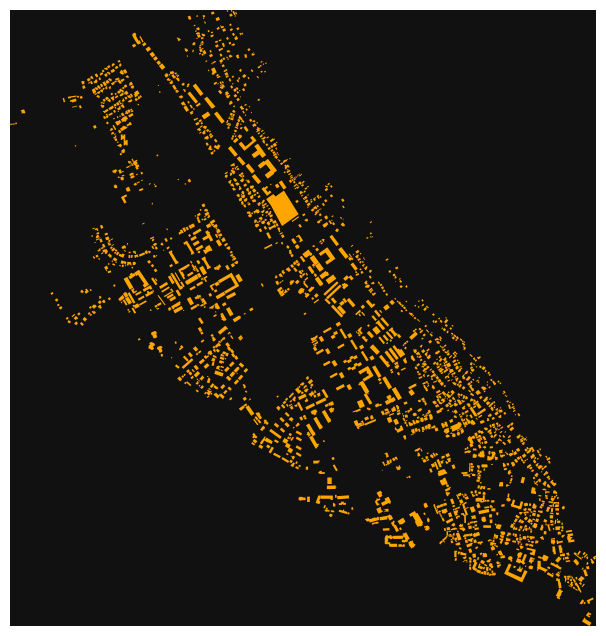

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [132]:
plt.figure()

ox.plot_footprints(df_residential)
# ox.plot_graph(df_path_bike)

In [135]:
def calculate_max_ds(centroid, features):
    if len(features) == 0:
        return 0

    min_dist = features.apply(lambda feature: ox.distance.euclidean_dist_vec(centroid.x, centroid.y, feature.x, feature.y)).min()
    min_time = min_dist / WALKING_SPEED_MS / 60

    if min_time > 25:
        return 0

    return min((25 - min_time) / 20, 1)

def calculate_lcs(node):
    total_score = 0
    center = node['geometry'].centroid

    if node['edges_walk_dist'] < INFRASTRUCTURE_CUTOFF_DIST:
        closest_street = df_path_walk.edges[node['edges_walk']]
        sidewalk_width = float(closest_street.get('width', default_sidewalk_width))

        if sidewalk_width >= 1:
            total_score += 3

        if sidewalk_width >= 2:
            total_score += 1

        if closest_street.get("lit", default_sidewalk_lit) == 'yes':
            total_score += 1      

    if node['edges_bike_dist'] < INFRASTRUCTURE_CUTOFF_DIST:
        closest_path = df_path_bike.edges[node['edges_bike']]

        if float(closest_path.get('width', default_bikepath_width)) >= 1.5:
            total_score += 3

        if closest_path.get("lit", default_bikepath_lit) == 'yes':
            total_score += 1 

    for score, df in df_amenities:
        total_score += score * calculate_max_ds(center, df)

    return total_score

In [140]:
df_residential['lsc'] = df_residential.apply(calculate_lcs, axis=1)

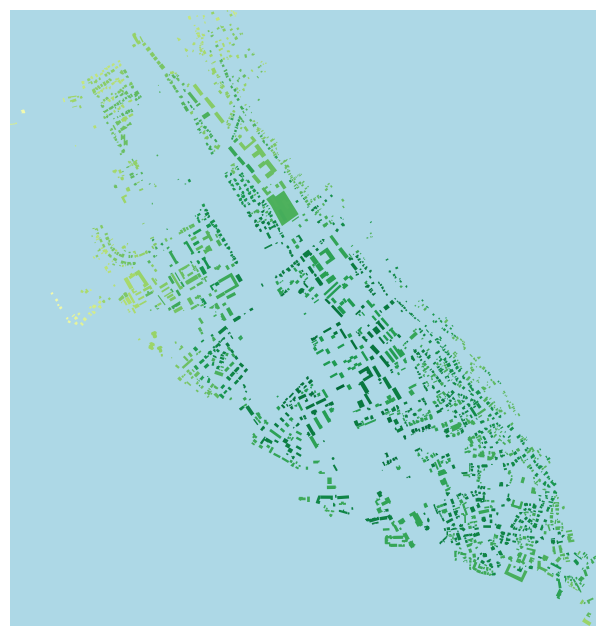

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [141]:
cmap = mpl.colormaps['RdYlGn']
ox.plot_footprints(df_residential, color=cmap((df_residential['lsc'] * 1.0 / df_residential['lsc'].max())), bgcolor='lightblue', figsize=(8, 8))


<AxesSubplot: >

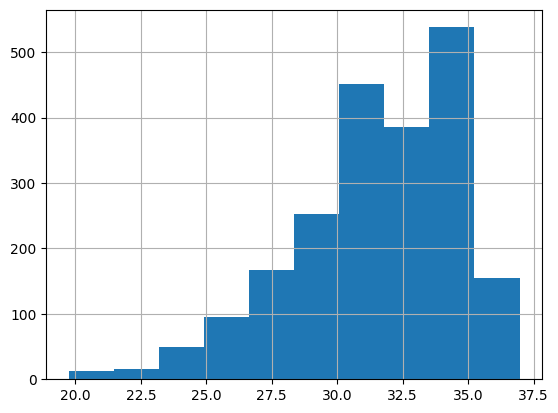

In [142]:
df_residential['lsc'].hist()

In [116]:
df_amenities

[(3,
  0     POINT (543955.364 5224189.634)
  1     POINT (543981.236 5224154.151)
  2     POINT (543302.479 5224796.622)
  3     POINT (543270.180 5224520.004)
  4     POINT (542761.351 5226196.094)
  5     POINT (542759.522 5226182.833)
  6     POINT (542820.469 5226255.612)
  7     POINT (542318.933 5226595.890)
  8     POINT (543315.764 5224803.754)
  9     POINT (543317.441 5224852.199)
  10    POINT (543199.553 5224958.739)
  11    POINT (543091.157 5225276.652)
  12    POINT (542983.290 5225434.524)
  13    POINT (542336.878 5226561.244)
  14    POINT (543099.662 5225296.996)
  15    POINT (543960.881 5224168.181)
  16    POINT (542754.616 5226090.100)
  17    POINT (543492.070 5224417.562)
  18    POINT (542972.020 5225450.501)
  19    POINT (543092.849 5225279.420)
  20    POINT (543080.391 5225318.527)
  dtype: geometry),
 (3,
  0     POINT (543088.739 5225305.851)
  1     POINT (543397.435 5224415.757)
  2     POINT (543566.208 5224343.914)
  3     POINT (543446.959 5224903.

<AxesSubplot: >

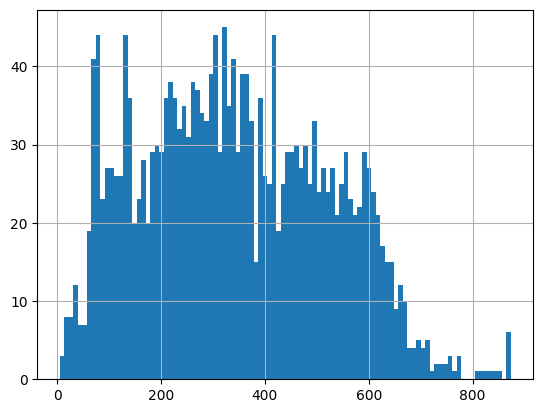

In [60]:
df_residential['edges_bike_dist'].hist(bins=100)

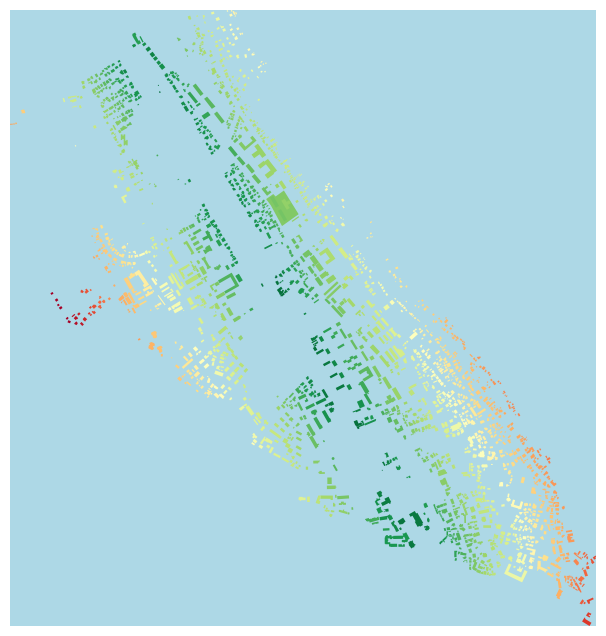

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [59]:
cmap = mpl.colormaps['RdYlGn']
ox.plot_footprints(df_residential, color=cmap((1.0 - df_residential['edges_bike_dist'] * 1.0 / df_residential['edges_bike_dist'].max())), bgcolor='lightblue', figsize=(8, 8))


In [112]:
df_residential.centroid

0       POINT (543099.109 5225340.048)
1       POINT (543126.060 5224813.453)
2       POINT (543140.231 5224758.061)
3       POINT (543197.332 5224874.175)
4       POINT (543122.757 5224920.043)
                     ...              
2118    POINT (542058.478 5226101.753)
2119    POINT (542650.430 5226239.630)
2120    POINT (542933.042 5226000.787)
2121    POINT (543423.464 5225264.721)
2122    POINT (543896.348 5224497.625)
Length: 2123, dtype: geometry

In [95]:
df_path_drive.nodes(keys=True, data=True)

TypeError: NodeView.__call__() got an unexpected keyword argument 'keys'